Checking model path: models\best.pt
Model loaded successfully.
Processing image: data\base_dataset\Living-Room-9\valid\images\102_jpg.rf.9536ff1b9a9768648ae995332efb79f9.jpg


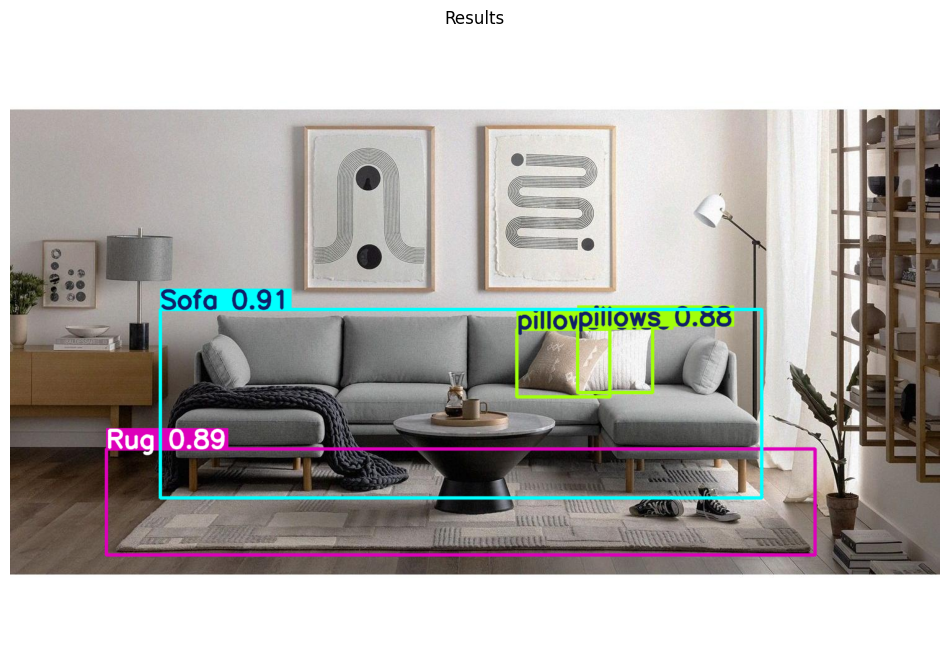

In [10]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# --- Configuration ---
# Define base paths using absolute positioning
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
MODEL_PATH = os.path.join(BASE_DIR, "models", "best.pt")
DATASET_DIR = os.path.join(BASE_DIR, "data", "base_dataset", "Living-Room-9", "valid", "images")

# Define target classes for filtering
TARGET_CLASSES = ["Sofa", "Rug", "Pillows"] 

# 1. Model Verification
rel_model_path = os.path.relpath(MODEL_PATH, BASE_DIR)
print(f"Checking model path: {rel_model_path}")

if not os.path.exists(MODEL_PATH):
    # Fallback to the history directory if the exported model is missing
    ALT_PATH = os.path.join(BASE_DIR, "models_history", "yolov8m_balanced_v1", "weights", "best.pt")
    if os.path.exists(ALT_PATH):
        print(f"Model found in alternative path: {os.path.relpath(ALT_PATH, BASE_DIR)}")
        MODEL_PATH = ALT_PATH
    else:
        raise FileNotFoundError("Model file not found. Please verify the training process completed successfully.")

# 2. Load Model
try:
    model = YOLO(MODEL_PATH)
    print("Model loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Failed to initialize YOLO model: {e}")

# 3. Class ID Mapping
# YOLO requires integer IDs for filtering, so we map string names to IDs
available_classes = model.names 
str_to_id = {v: k for k, v in available_classes.items()}

filter_ids = []
for name in TARGET_CLASSES:
    # Case-insensitive check just in case
    match = next((k for k in str_to_id.keys() if k.lower() == name.lower()), None)
    if match:
        filter_ids.append(str_to_id[match])
    else:
        print(f"Warning: Class '{name}' not found in model training data.")

if not filter_ids:
    print("No target classes found in model. Proceeding without filters.")
    filter_ids = None

# 4. Image Selection and Inference
if os.path.exists(DATASET_DIR):
    image_files = [f for f in os.listdir(DATASET_DIR) if f.endswith(".jpg")]
    
    if image_files:
        # Select the image for testing
        target_image = os.path.join(DATASET_DIR, image_files[7])
        
        # Sanitized print for logs
        print(f"Processing image: {os.path.relpath(target_image, BASE_DIR)}")
        
        # Run inference with class filtering
        results = model.predict(target_image, conf=0.25, classes=filter_ids, verbose=False)
        
        # 5. Visualization
        # ultralytics returns BGR images; convert to RGB for matplotlib
        res_plotted = results[0].plot()
        res_plotted_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(12, 12))
        plt.imshow(res_plotted_rgb)
        plt.axis('off')
        plt.title("Results")
        plt.show()
    else:
        print("Directory exists but contains no .jpg images.")
else:
    print(f"Image directory not found: {os.path.relpath(DATASET_DIR, BASE_DIR)}")